<a href="https://colab.research.google.com/github/arebs23/Document-cleaning/blob/main/Document_Denoising_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an exploratory CNN with the objective of denoising documents. The data is available on Kaggle. This was an interesting assignment and will be meaningful to the real world (Cleaning up scanned documents and images of faxes.) <br><br>
Kaggle Competition: <br>
https://www.kaggle.com/c/denoising-dirty-documents

In [3]:
#Import Dependencies
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
from time import time
import os
import sys
import pickle as pkl
from keras.models import Sequential,Model, load_model
from keras.layers import Dropout, Flatten,Dense, GlobalAveragePooling2D, Input 
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator 
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import plot_model
import seaborn as sns
%matplotlib inline
import unittest
from sklearn.model_selection import train_test_split

# Data Processing

# New section

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dat.zip to dat.zip


In [ ]:
from zipfile import ZipFile
file_name = 'dat.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('done')

done


# New section

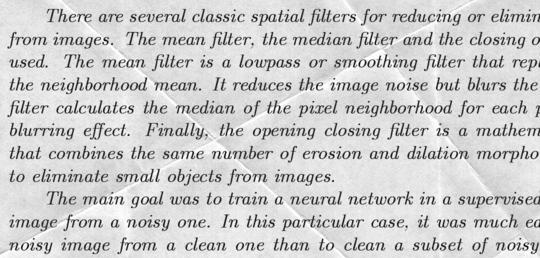

In [ ]:
train_images = os.listdir('/content/dat/train')
test_images = os.listdir('/content/dat/test')
clean_images = os.listdir('/content/dat/train_cleaned')
Image.open('/content/dat/train/' + train_images[0])

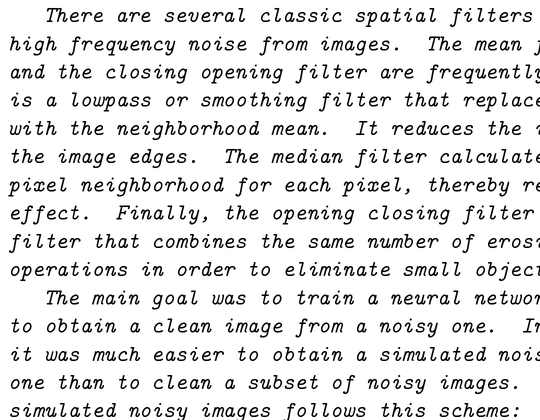

In [ ]:
Image.open('/content/dat/train_cleaned/' + train_images[1])

In [ ]:
test_image = Image.open('/content/dat/train/' + train_images[10])
test_image.size

(540, 420)

(540, 258) looks like a common size for images in this dataset. Will set as default size.

In [ ]:
def set_common_size(img_link, std_size = (256, 540)):
    '''Function will take in the argument of a link to an image and return the image 
    with the standard size.'''
    img = Image.open(img_link)
    img = image.img_to_array(img)
    img = np.resize(img, std_size)
    return img / 255
set_common_size('/content/dat/train/' + train_images[10])

array([[0.90588236, 0.8980392 , 0.89411765, ..., 0.8784314 , 0.8666667 ,
        0.87058824],
       [0.9098039 , 0.91764706, 0.9137255 , ..., 0.8666667 , 0.8392157 ,
        0.84313726],
       [0.8862745 , 0.89411765, 0.8862745 , ..., 0.8509804 , 0.85490197,
        0.85490197],
       ...,
       [0.70980394, 0.78039217, 0.8980392 , ..., 0.8392157 , 0.84705883,
        0.85490197],
       [0.8627451 , 0.9411765 , 0.99215686, ..., 0.8901961 , 0.83137256,
        0.84705883],
       [0.9882353 , 0.99607843, 0.99215686, ..., 0.9372549 , 0.8745098 ,
        0.84313726]], dtype=float32)

In [ ]:
class TestFileSize(unittest.TestCase):
    def test_file_size(self):
        file = set_common_size('/content/dat/train/' + train_images[10])
        self.assertEqual(file.size, (540, 256))

In [ ]:
train_data = []
test_data = []
cleaned_data = []
for img in train_images:
    img_file = set_common_size('/content/dat/train/' + img)
    train_data.append(img_file)
for img in test_images:
    img_file = set_common_size('/content/dat/test/' + img)
    test_data.append(img_file)
for img in clean_images:
    img_file = set_common_size('/content/dat/train_cleaned/' + img)
    cleaned_data.append(img_file)
train_data = np.asarray(train_data)
test_data = np.asarray(test_data)
cleaned_data = np.asarray(cleaned_data)

In [ ]:
train_data[0]

array([[0.90588236, 0.8980392 , 0.89411765, ..., 0.8784314 , 0.8666667 ,
        0.87058824],
       [0.9098039 , 0.91764706, 0.9137255 , ..., 0.8666667 , 0.8392157 ,
        0.84313726],
       [0.8862745 , 0.89411765, 0.8862745 , ..., 0.8509804 , 0.85490197,
        0.85490197],
       ...,
       [0.70980394, 0.78039217, 0.8980392 , ..., 0.8392157 , 0.84705883,
        0.85490197],
       [0.8627451 , 0.9411765 , 0.99215686, ..., 0.8901961 , 0.83137256,
        0.84705883],
       [0.9882353 , 0.99607843, 0.99215686, ..., 0.9372549 , 0.8745098 ,
        0.84313726]], dtype=float32)

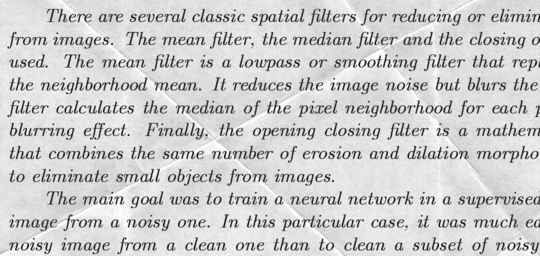

In [ ]:
img = np.array((train_data[0] * 255), dtype=np.uint8)
Image.fromarray(img)

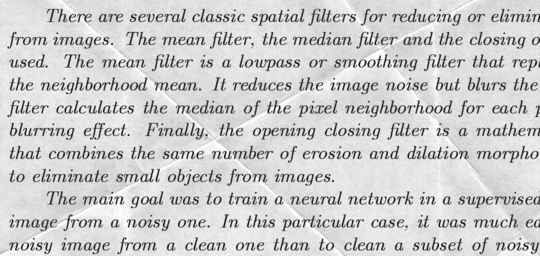

In [ ]:
def return_as_image(np_array):
    return Image.fromarray(np.array((np_array * 255), dtype=np.uint8))
return_as_image(train_data[0])

### Objective
A convolutional autoencoder will compress an image and then uncompress the image. The goal of this project is to remove the noise observed above (crumpled lines). 


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_data, cleaned_data, test_size=0.1, random_state=42)

In [ ]:
len(x_train), len(x_test)

(129, 15)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], 256, 540, 1)
x_test = x_test.reshape(x_test.shape[0], 256, 540, 1)
y_train = y_train.reshape(y_train.shape[0], 256, 540, 1)
y_test = y_test.reshape(y_test.shape[0], 256, 540, 1)

In [ ]:
x_train[0].shape

(256, 540, 1)

In [ ]:
input_shape = x_train[0].shape
input_layer = Input(input_shape)

In [ ]:
#Layer 1
model = Sequential()
model.add(Conv2D(64, 3, activation='relu', padding='same', input_shape=input_shape))
model.add(MaxPooling2D(2))
model.add(Dropout(0.4))
#Layer 2
model.add(Conv2D(128, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(2))
model.add(MaxPooling2D(2))
model.add(Dropout(0.4))
#Bottleneck
#Layer 1 Upsizing
model.add(UpSampling2D(2))
model.add(UpSampling2D(2))
model.add(Conv2DTranspose(128, 3, activation='relu', padding='same'))
#Layer 2 Upsizing
model.add(UpSampling2D(2))
model.add(Conv2DTranspose(64, 3, activation='relu', padding='same'))
model.add(Conv2DTranspose(1, 3, activation='sigmoid', padding='same'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 540, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 270, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 270, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 270, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 135, 128)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 135, 128)      0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 128, 270, 128)     0

In [ ]:
model.compile(optimizer='adadelta', loss='binary_crossentropy')
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max') 
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
hist = model.fit(
            x_train, y_train, 
            epochs=200,
            batch_size=1,
            shuffle=True,
            validation_data=(x_test, y_test), 
            verbose=1,
            callbacks=[tensorboard, early_stop, checkpoint]
)

Epoch 1/200
129/129 [==============================] - 12s 35ms/step - loss: 0.6298 - val_loss: 0.6256
Epoch 2/200
129/129 [==============================] - 4s 32ms/step - loss: 0.5741 - val_loss: 0.5798
Epoch 3/200
129/129 [==============================] - 4s 32ms/step - loss: 0.5080 - val_loss: 0.5207
Epoch 4/200
129/129 [==============================] - 4s 32ms/step - loss: 0.4395 - val_loss: 0.4596
Epoch 5/200
129/129 [==============================] - 4s 32ms/step - loss: 0.3855 - val_loss: 0.4155
Epoch 6/200
129/129 [==============================] - 4s 32ms/step - loss: 0.3577 - val_loss: 0.3910
Epoch 7/200
129/129 [==============================] - 4s 32ms/step - loss: 0.3518 - val_loss: 0.3787
Epoch 8/200
129/129 [==============================] - 4s 32ms/step - loss: 0.3477 - val_loss: 0.3735
Epoch 9/200
129/129 [==============================] - 4s 33ms/step - loss: 0.3495 - val_loss: 0.3715
Epoch 10/200
129/129 [==============================] - 4s 33ms/step - loss: 0.35

In [ ]:
model.save('model.h5')

In [ ]:
model2 = load_model('model.h5')

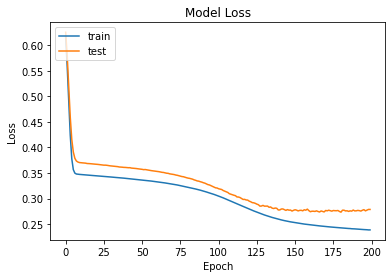

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

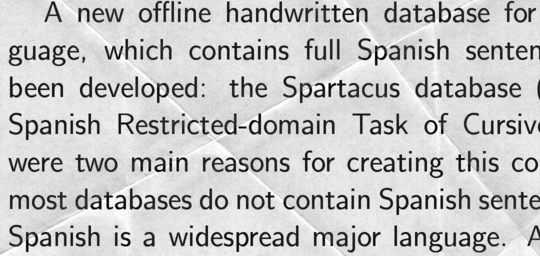

In [ ]:
img = np.array((test_data[0] * 255), dtype=np.uint8)
Image.fromarray(img)

In [ ]:
def predict_transform(img, model):
    img = img.reshape(256, 540, 1)
    img_clean = model.predict(np.array([img]))[0]
    reshaped_img = img_clean.reshape(256, 540)
    image_array = np.array((reshaped_img * 255), dtype=np.uint8)
    return Image.fromarray(image_array)

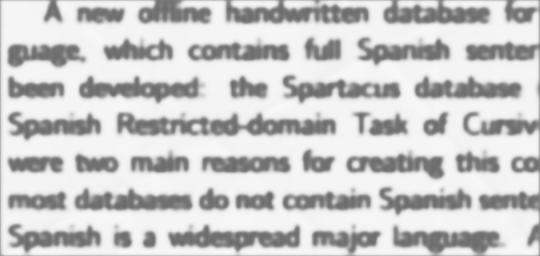

In [ ]:
cleaned_img = predict_transform(test_data[0], model)
cleaned_img

The model is cleaning the noises from the image, but the characters in the document are blurry. Let's try a model with less layers to denoise the images.

In [ ]:
#Layer 1
model = Sequential()
model.add(Conv2D(64, 3, activation='relu', padding='same', input_shape=input_shape))
model.add(MaxPooling2D(2))
model.add(Dropout(0.4))

#Bottleneck

#Layer 1 Upsizing
model.add(UpSampling2D(2))
model.add(Conv2DTranspose(64, 3, activation='relu', padding='same'))
model.add(Conv2DTranspose(1, 3, activation='sigmoid', padding='same'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 256, 540, 64)      640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 270, 64)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 270, 64)      0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 256, 540, 64)      0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 256, 540, 64)      36928     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 256, 540, 1)       577       
Total params: 38,145
Trainable params: 38,145
Non-trainable params: 0
__________________________________________________

In [ ]:
model.compile(optimizer='adadelta', loss='binary_crossentropy')
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max') 
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
hist2 = model.fit(
            x_train, y_train, 
            epochs=200,
            batch_size=1,
            shuffle=True,
            validation_data=(x_test, y_test), 
            verbose=1,
            callbacks=[tensorboard, early_stop, checkpoint]
)

Epoch 1/200
129/129 [==============================] - 3s 18ms/step - loss: 0.6474 - val_loss: 0.6292
Epoch 2/200
129/129 [==============================] - 2s 17ms/step - loss: 0.6360 - val_loss: 0.6172
Epoch 3/200
129/129 [==============================] - 2s 17ms/step - loss: 0.6228 - val_loss: 0.6040
Epoch 4/200
129/129 [==============================] - 2s 17ms/step - loss: 0.6091 - val_loss: 0.5895
Epoch 5/200
129/129 [==============================] - 2s 17ms/step - loss: 0.5936 - val_loss: 0.5727
Epoch 6/200
129/129 [==============================] - 2s 17ms/step - loss: 0.5760 - val_loss: 0.5531
Epoch 7/200
129/129 [==============================] - 2s 17ms/step - loss: 0.5566 - val_loss: 0.5315
Epoch 8/200
129/129 [==============================] - 2s 18ms/step - loss: 0.5360 - val_loss: 0.5083
Epoch 9/200
129/129 [==============================] - 2s 17ms/step - loss: 0.5122 - val_loss: 0.4836
Epoch 10/200
129/129 [==============================] - 2s 17ms/step - loss: 0.485

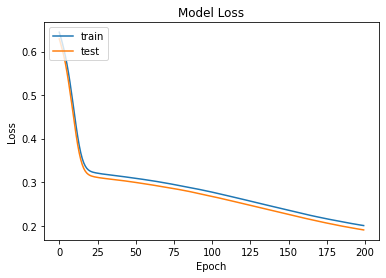

In [ ]:
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Loss has reduced by 3.5% and the validation loss looks much smoother when compared to the first model. Next step is to check how this helps the look of some test images.

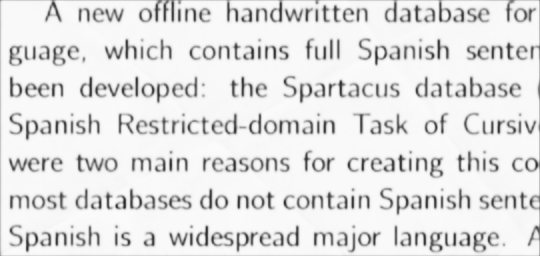

In [ ]:
cleaned_img = predict_transform(test_data[0], model)
cleaned_img

# This looks much cleaner now!!! This can be easily fed into an OCR process.

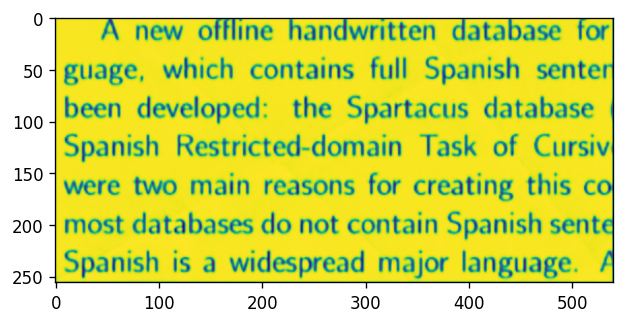

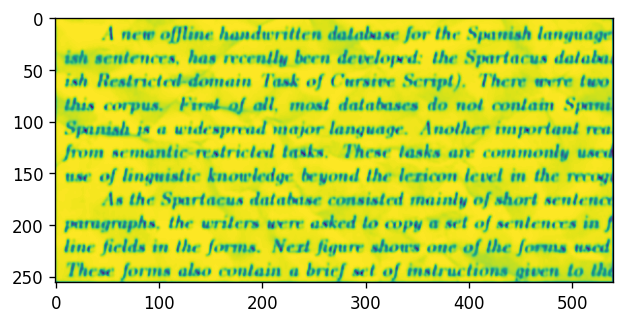

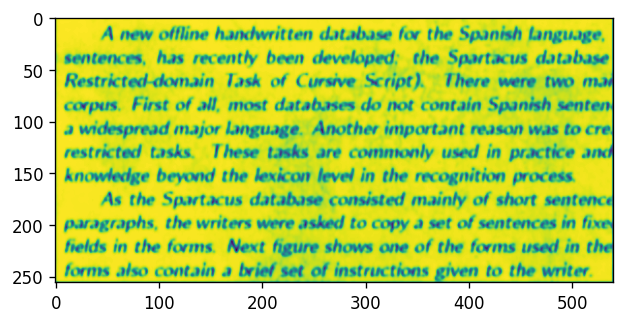

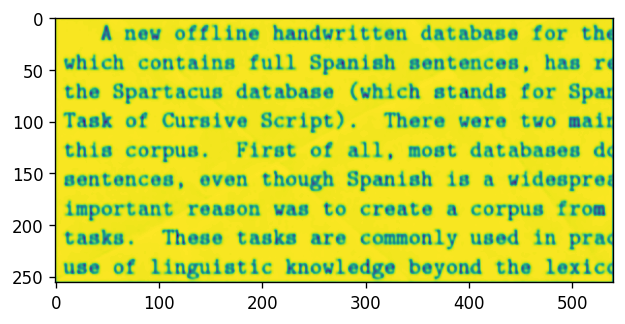

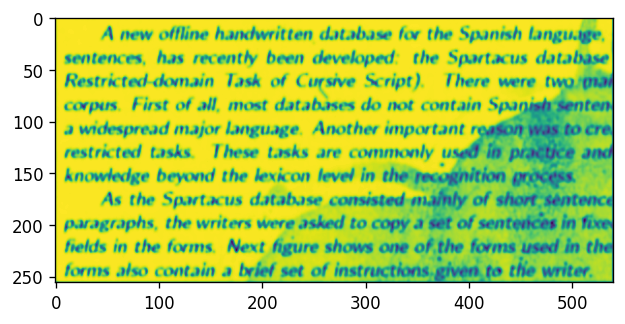

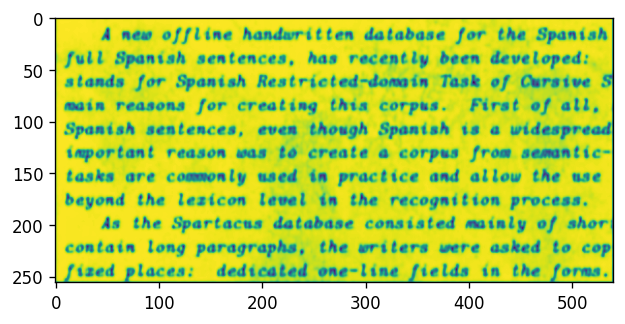

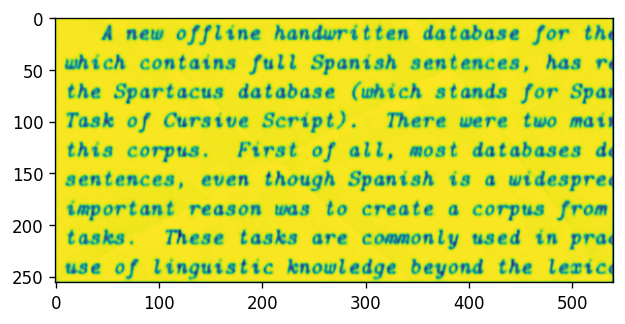

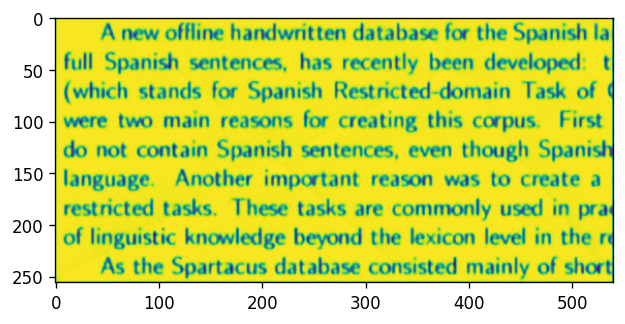

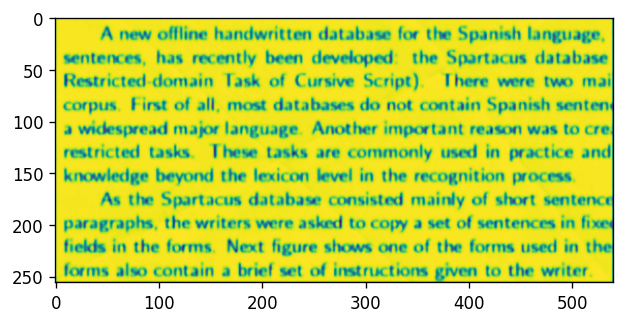

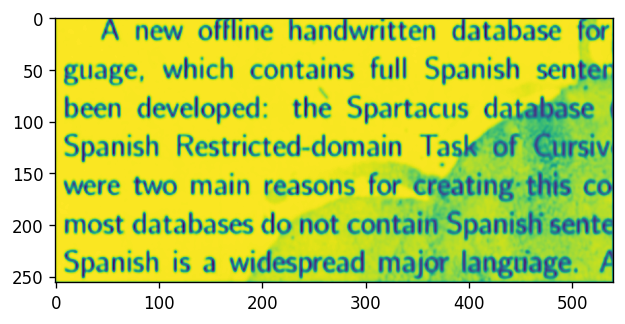

In [ ]:
for i in range(10):
    cleaned_img = predict_transform(test_data[i], model)
    plt.figure(figsize=(6, 4), dpi=120, facecolor='w', edgecolor='k')
    plt.imshow(cleaned_img)

Overall the images look much cleaner. There are probably some more hyperparameter changes to make to improve further. The image at index 3 has some more noise to clean up, but overall, the model reduces the noise and maintains the clarity of the fonts.  